/usr/local/lib/python3.11/dist-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)



🐍 Bonus: Naive Python (reference)
  n=64: 0.0060 ± 0.0003 GFLOPS (t=0.0873s)
  n=128: 0.0056 ± 0.0007 GFLOPS (t=0.7603s)
  n=192: 0.0057 ± 0.0007 GFLOPS (t=2.5258s)
  n=256: 0.0054 ± 0.0007 GFLOPS (t=6.2787s)
  n=320 (skipped to keep runtime sane)

🔢 Bonus: NumPy (CPU BLAS)
  n=64: 35.00 ± 7.35 GFLOPS (t=0.016 ms)
  n=128: 56.63 ± 2.26 GFLOPS (t=0.074 ms)
  n=192: 63.43 ± 4.71 GFLOPS (t=0.224 ms)
  n=256: 65.99 ± 3.18 GFLOPS (t=0.509 ms)
  n=320: 69.26 ± 3.17 GFLOPS (t=0.947 ms)

🧱 Bonus: Numba JIT (naive + blocked)
  n=64: 0.92 ± 0.03 GFLOPS (blocked bs=64)
  n=128: 1.60 ± 0.05 GFLOPS (blocked bs=64)
  n=192: 1.45 ± 0.21 GFLOPS (blocked bs=64)
  n=256: 1.63 ± 0.04 GFLOPS (blocked bs=64)
  n=320: 1.55 ± 0.12 GFLOPS (blocked bs=64)
Compiling OpenMP C++: g++ -O3 -fopenmp -march=native -shared -fPIC mm_openmp.cpp -o mm_openmp.so

⚙️  Bonus: OpenMP C++ (-O3, blocked)
  n=64: 14.47 ± 1.83 GFLOPS (block=64)
  n=128: 13.57 ± 1.26 GFLOPS (block=64)
  n=192: 13.89 ± 0.68 GFLOPS (block=64)
  n=

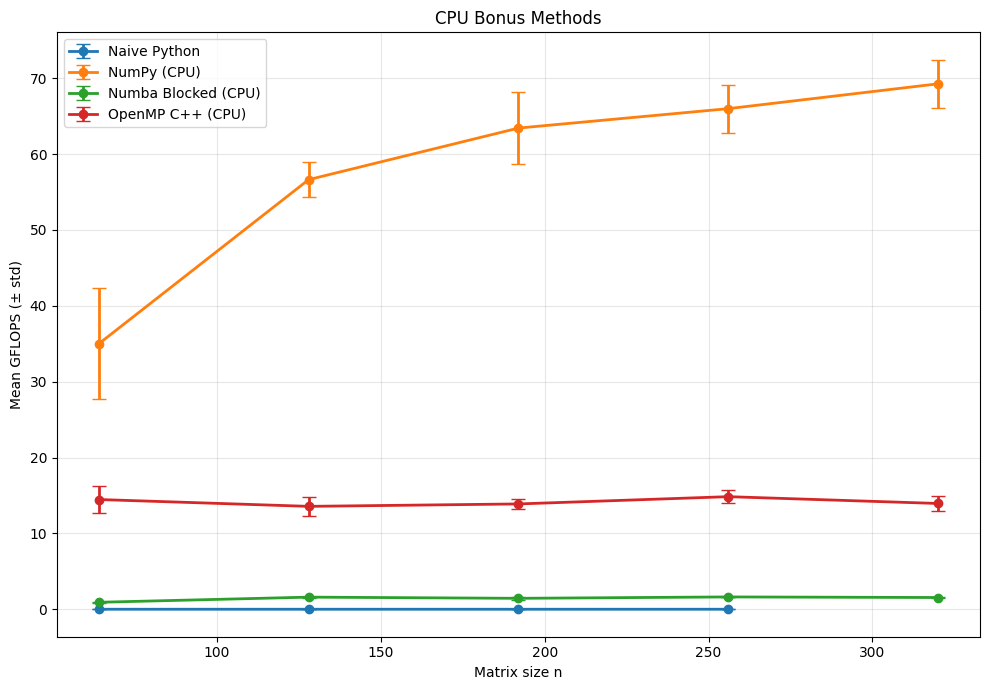

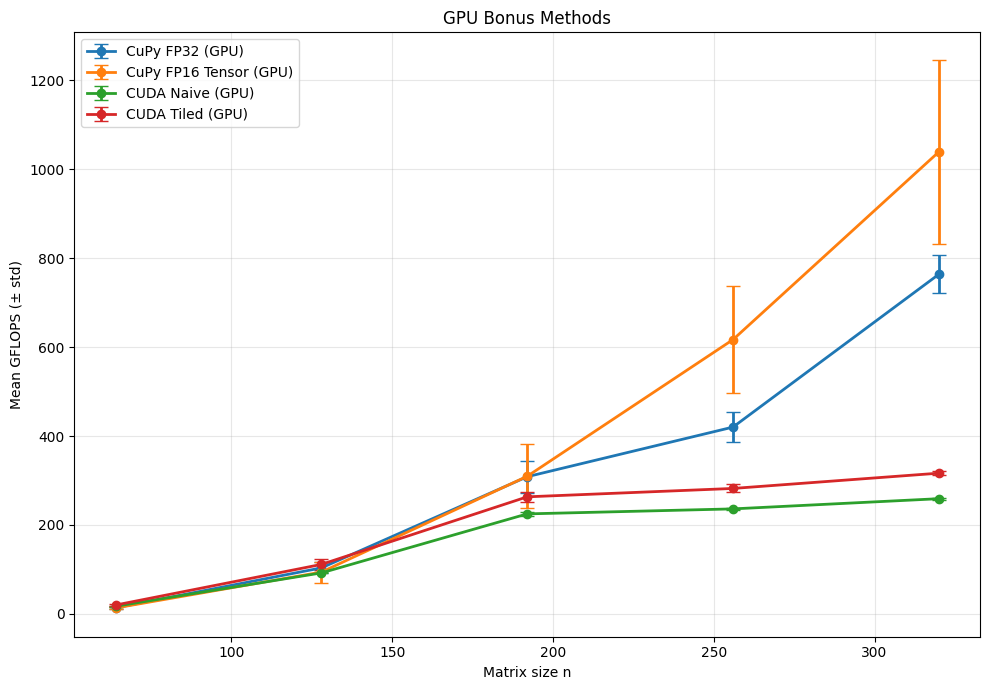

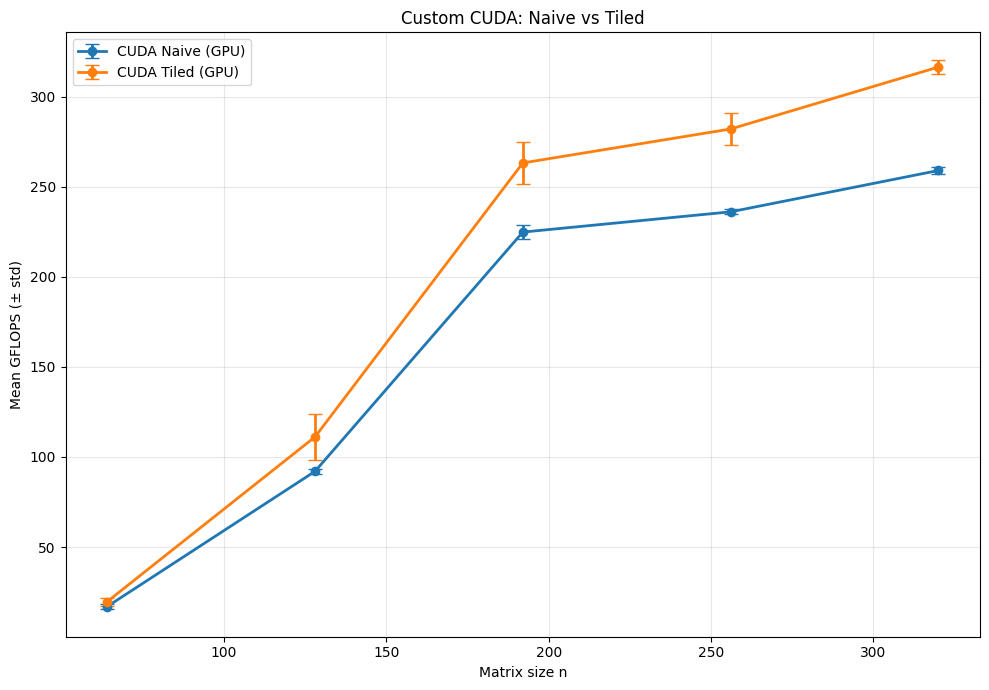

In [ ]:

!pip -q install numba cupy-cuda12x torch torchvision --extra-index-url https://download.pytorch.org/whl/cu121

# %%
import os, sys, time, math, statistics, subprocess, ctypes, textwrap, shutil, platform, warnings
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import matplotlib.pyplot as plt

# runtime checks
try:
    import cupy as cp
    CUPY = True
except Exception as e:
    CUPY = False
    warnings.warn(f"CuPy not available: {e}")

try:
    import torch
    TORCH = True
except Exception as e:
    TORCH = False
    warnings.warn(f"PyTorch not available: {e}")

try:
    import numba
    from numba import njit, prange
    NUMBA = True
except Exception as e:
    NUMBA = False
    warnings.warn(f"Numba not available: {e}")

# %%
def gflops(n: int, seconds: float) -> float:
    # 2n^3 - n^2 floating ops
    return (2*n**3 - n**2) / (seconds * 1e9)

def sizes_default():
    # Keep consistent with your main report
    return [64, 128, 192, 256, 320]

def repeat_bench(fn, n, iters=30, warmup=3):
    # returns (mean_gflops, std_gflops, mean_time)
    times = []
    # warmup
    for _ in range(warmup):
        fn()
    for _ in range(iters):
        t0 = time.perf_counter()
        fn()
        t1 = time.perf_counter()
        times.append(t1 - t0)
    gfs = [gflops(n, t) for t in times]
    return statistics.mean(gfs), (statistics.stdev(gfs) if len(gfs) > 1 else 0.0), statistics.mean(times)

# %%
# ---------------------
# 1) CPU – Naive Python
# ---------------------
def naive_python_mm(A: np.ndarray, B: np.ndarray):
    n = A.shape[0]
    C = np.zeros((n,n), dtype=A.dtype)
    for i in range(n):
        for j in range(n):
            s = 0.0
            for k in range(n):
                s += float(A[i,k]) * float(B[k,j])
            C[i,j] = s
    return C

def bench_naive_python(ns: List[int], iters=30) -> Dict:
    print("\n🐍 Bonus: Naive Python (reference)")
    out = {'sizes':[], 'mean_gflops':[], 'std_gflops':[], 'times':[]}
    for n in ns:
        if n > 256:
            # keep small; otherwise it's painfully slow in Colab
            print(f"  n={n} (skipped to keep runtime sane)")
            continue
        A = np.random.rand(n,n).astype(np.float32)
        B = np.random.rand(n,n).astype(np.float32)
        mean_gf, std_gf, mean_t = repeat_bench(lambda: naive_python_mm(A,B), n, iters=iters)
        print(f"  n={n}: {mean_gf:.4f} ± {std_gf:.4f} GFLOPS (t={mean_t:.4f}s)")
        out['sizes'].append(n); out['mean_gflops'].append(mean_gf); out['std_gflops'].append(std_gf); out['times'].append(mean_t)
    return out

# %%
# --------------------
# 2) CPU – NumPy (BLAS)
# --------------------
def bench_numpy(ns: List[int], iters=30) -> Dict:
    print("\n🔢 Bonus: NumPy (CPU BLAS)")
    out = {'sizes':[], 'mean_gflops':[], 'std_gflops':[], 'times':[]}
    for n in ns:
        A = np.random.rand(n,n).astype(np.float32)
        B = np.random.rand(n,n).astype(np.float32)
        mean_gf, std_gf, mean_t = repeat_bench(lambda: A @ B, n, iters=iters)
        print(f"  n={n}: {mean_gf:.2f} ± {std_gf:.2f} GFLOPS (t={mean_t*1e3:.3f} ms)")
        out['sizes'].append(n); out['mean_gflops'].append(mean_gf); out['std_gflops'].append(std_gf); out['times'].append(mean_t)
    return out

# %%
# ---------------------------------
# 3) CPU – Numba JIT (naive & blocked)
# ---------------------------------
# ---------- PATCH: replace your Numba section with this ----------
if NUMBA:
    from numba import njit, prange

    @njit(nopython=True, fastmath=True)
    def numba_naive(A, B):
        n = A.shape[0]
        C = np.zeros((n, n), dtype=np.float32)
        for i in range(n):
            for j in range(n):
                s = 0.0
                for k in range(n):
                    s += A[i, k] * B[k, j]
                C[i, j] = s
        return C

    @njit(nopython=True, parallel=True, fastmath=True)
    def numba_blocked(A, B, bs):
        n = A.shape[0]
        C = np.zeros((n, n), dtype=np.float32)

        nbi = (n + bs - 1) // bs  # number of i-blocks

        # parallel over i-blocks: constant step size (1) -> OK for prange
        for iib in prange(nbi):
            i0 = iib * bs
            i1 = i0 + bs
            if i1 > n:
                i1 = n
            for kk in range(0, n, bs):
                k1 = kk + bs
                if k1 > n:
                    k1 = n
                for jj in range(0, n, bs):
                    j1 = jj + bs
                    if j1 > n:
                        j1 = n
                    for i in range(i0, i1):
                        for k in range(kk, k1):
                            aik = A[i, k]
                            for j in range(jj, j1):
                                C[i, j] += aik * B[k, j]
        return C

def bench_numba(ns: List[int], iters=30, block=64) -> Dict:
    if not NUMBA:
        print("\n❌ Numba not available; skipping.")
        return {}
    print("\n🧱 Bonus: Numba JIT (naive + blocked)")
    out = {'sizes': [], 'mean_gflops': [], 'std_gflops': [], 'times': []}
    for n in ns:
        A = np.random.rand(n, n).astype(np.float32)
        B = np.random.rand(n, n).astype(np.float32)
        # JIT compile once
        _ = numba_naive(A, B)
        _ = numba_blocked(A, B, block)
        # measure blocked variant
        mean_gf, std_gf, mean_t = repeat_bench(lambda: numba_blocked(A, B, block), n, iters=iters)
        print(f"  n={n}: {mean_gf:.2f} ± {std_gf:.2f} GFLOPS (blocked bs={block})")
        out['sizes'].append(n); out['mean_gflops'].append(mean_gf); out['std_gflops'].append(std_gf); out['times'].append(mean_t)
    return out
# ---------- END PATCH ----------


# %%
# ---------------------------------
# 4) CPU – C/OpenMP (-O3 -fopenmp)
# ---------------------------------
def build_openmp_so():
    code = r"""
    #include <omp.h>
    #include <stdint.h>
    #include <stdlib.h>

    extern "C" {
    void mm_openmp(const float* A, const float* B, float* C, int n, int block) {
        // simple blocked i-k-j loop with OpenMP parallel for
        #pragma omp parallel for
        for (int ii = 0; ii < n; ii += block) {
            int i_end = ii + block; if (i_end > n) i_end = n;
            for (int kk = 0; kk < n; kk += block) {
                int k_end = kk + block; if (k_end > n) k_end = n;
                for (int jj = 0; jj < n; jj += block) {
                    int j_end = jj + block; if (j_end > n) j_end = n;
                    for (int i = ii; i < i_end; ++i) {
                        for (int k = kk; k < k_end; ++k) {
                            float aik = A[i*n + k];
                            for (int j = jj; j < j_end; ++j) {
                                C[i*n + j] += aik * B[k*n + j];
                            }
                        }
                    }
                }
            }
        }
    }
    }
    """
    src = Path("mm_openmp.cpp")
    so  = Path("mm_openmp.so")
    src.write_text(code)
    cmd = ["g++", "-O3", "-fopenmp", "-march=native", "-shared", "-fPIC", str(src), "-o", str(so)]
    print("Compiling OpenMP C++:", " ".join(cmd))
    rc = subprocess.call(cmd)
    if rc != 0 or not so.exists():
        raise RuntimeError("Failed to build OpenMP shared object.")
    return so

def bench_openmp(ns: List[int], iters=30, block=64) -> Dict:
    try:
        so = build_openmp_so()
        lib = ctypes.cdll.LoadLibrary(str(so.resolve()))
        lib.mm_openmp.argtypes = [
            ctypes.POINTER(ctypes.c_float),
            ctypes.POINTER(ctypes.c_float),
            ctypes.POINTER(ctypes.c_float),
            ctypes.c_int, ctypes.c_int
        ]
        lib.mm_openmp.restype = None
    except Exception as e:
        print("\n❌ OpenMP build/load failed:", e)
        return {}

    print("\n⚙️  Bonus: OpenMP C++ (-O3, blocked)")
    out = {'sizes':[], 'mean_gflops':[], 'std_gflops':[], 'times':[]}
    for n in ns:
        A = np.random.rand(n,n).astype(np.float32)
        B = np.random.rand(n,n).astype(np.float32)
        C = np.zeros((n,n), dtype=np.float32)

        A_p = A.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
        B_p = B.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
        C_p = C.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

        def run():
            C.fill(0.0)
            lib.mm_openmp(A_p, B_p, C_p, n, block)

        mean_gf, std_gf, mean_t = repeat_bench(run, n, iters=iters)
        print(f"  n={n}: {mean_gf:.2f} ± {std_gf:.2f} GFLOPS (block={block})")
        out['sizes'].append(n); out['mean_gflops'].append(mean_gf); out['std_gflops'].append(std_gf); out['times'].append(mean_t)
    return out

# %%
# -------------------------------
# 5) GPU – CuPy / cuBLAS (FP32)
# -------------------------------
def bench_cupy_fp32(ns: List[int], iters=30) -> Dict:
    if not CUPY:
        print("\n❌ CuPy unavailable; skipping GPU tasks.")
        return {}
    print("\n🎮 Bonus: CuPy FP32 (cuBLAS SGEMM)")
    out = {'sizes':[], 'mean_gflops':[], 'std_gflops':[], 'times':[]}
    for n in ns:
        A = cp.random.random((n,n), dtype=cp.float32)
        B = cp.random.random((n,n), dtype=cp.float32)
        # warmup
        for _ in range(3):
            _ = A @ B
        cp.cuda.Stream.null.synchronize()

        def run():
            _ = A @ B
            cp.cuda.Stream.null.synchronize()
        mean_gf, std_gf, mean_t = repeat_bench(run, n, iters=iters, warmup=0)
        print(f"  n={n}: {mean_gf:.2f} ± {std_gf:.2f} GFLOPS")
        out['sizes'].append(n); out['mean_gflops'].append(mean_gf); out['std_gflops'].append(std_gf); out['times'].append(mean_t)
    return out

# %%
# ------------------------------------------
# 6) GPU – CuPy FP16 Tensor Core (accum FP32)
# ------------------------------------------
# Most NVIDIA GPUs with Tensor Cores will use them when inputs are float16 and math mode allows tensor ops.
def enable_cublas_tensor_math():
    try:
        from cupy.cuda import cublas
        handle = cublas.create()
        # 1 = CUBLAS_TENSOR_OP_MATH; 3 = CUBLAS_TF32_TENSOR_OP_MATH (Ampere+ w/ TF32)
        cublas.setMathMode(handle, 1)
        cublas.destroy(handle)
        print("   cuBLAS tensor math mode enabled (FP16 Tensor Cores).")
    except Exception as e:
        print("   Could not set cuBLAS math mode (will rely on defaults):", e)

def bench_cupy_fp16_tensor(ns: List[int], iters=30) -> Dict:
    if not CUPY:
        return {}
    print("\n🚀 Bonus: CuPy FP16 (Tensor Cores, accumulate FP32)")
    enable_cublas_tensor_math()  # tries to set tensor-op math mode

    out = {'sizes':[], 'mean_gflops':[], 'std_gflops':[], 'times':[]}
    for n in ns:
        # CuPy can't random() float16 directly — make float32 then cast
        A = cp.random.random((n, n), dtype=cp.float32).astype(cp.float16, copy=False)
        B = cp.random.random((n, n), dtype=cp.float32).astype(cp.float16, copy=False)

        # warmup
        for _ in range(3):
            _ = A @ B
        cp.cuda.Stream.null.synchronize()

        def run():
            _ = A @ B
            cp.cuda.Stream.null.synchronize()

        mean_gf, std_gf, mean_t = repeat_bench(run, n, iters=iters, warmup=0)
        print(f"  n={n}: {mean_gf:.2f} ± {std_gf:.2f} GFLOPS (FP16 inputs)")
        out['sizes'].append(n); out['mean_gflops'].append(mean_gf); out['std_gflops'].append(std_gf); out['times'].append(mean_t)
    return out


# %%
# ---------------------------------------
# 7) GPU – PyTorch TF32 (Ampere/Ada only)
# ---------------------------------------
def bench_torch_tf32(ns: List[int], iters=30) -> Dict:
    if not TORCH or not torch.cuda.is_available():
        print("\n❌ Torch CUDA not available; skipping TF32.")
        return {}
    cc_major, cc_minor = torch.cuda.get_device_capability()
    if cc_major < 8:
        print("\n⚠️  TF32 requires Ampere+ (SM 8.x). Current SM:", cc_major, cc_minor)
        return {}
    print("\n🔥 Bonus: PyTorch TF32 matmul (Ampere/Ada)")
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision('high')  # enable TF32 kernels
    device = torch.device('cuda')

    out = {'sizes':[], 'mean_gflops':[], 'std_gflops':[], 'times':[]}
    for n in ns:
        A = torch.rand((n,n), dtype=torch.float32, device=device)
        B = torch.rand((n,n), dtype=torch.float32, device=device)
        # warmup
        for _ in range(3):
            _ = torch.matmul(A,B)
        torch.cuda.synchronize()

        def run():
            _ = torch.matmul(A,B)
            torch.cuda.synchronize()
        mean_gf, std_gf, mean_t = repeat_bench(run, n, iters=iters, warmup=0)
        print(f"  n={n}: {mean_gf:.2f} ± {std_gf:.2f} GFLOPS (TF32)")
        out['sizes'].append(n); out['mean_gflops'].append(mean_gf); out['std_gflops'].append(std_gf); out['times'].append(mean_t)
    return out

# %%
# ------------------------------------------------
# 8) GPU – Custom CUDA kernels (naive & tiled)
# ------------------------------------------------
CUDA_NAIVE = r'''
extern "C" __global__
void matmul_naive(const float* A, const float* B, float* C, int n){
    int row = blockDim.y * blockIdx.y + threadIdx.y;
    int col = blockDim.x * blockIdx.x + threadIdx.x;
    if(row >= n || col >= n) return;
    float sum = 0.f;
    for(int k=0;k<n;++k){
        sum += A[row*n + k] * B[k*n + col];
    }
    C[row*n + col] = sum;
}
'''

# 32x32 tile with shared memory; simple version
CUDA_TILED = r'''
#ifndef TILE
#define TILE 32
#endif
extern "C" __global__
void matmul_tiled(const float* __restrict__ A,
                  const float* __restrict__ B,
                  float* __restrict__ C,
                  int n){
    __shared__ float As[TILE][TILE];
    __shared__ float Bs[TILE][TILE];

    int row = blockDim.y * blockIdx.y + threadIdx.y;
    int col = blockDim.x * blockIdx.x + threadIdx.x;
    float sum = 0.f;

    for(int t=0; t < (n + TILE - 1)/TILE; ++t){
        int a_col = t*TILE + threadIdx.x;
        int b_row = t*TILE + threadIdx.y;
        As[threadIdx.y][threadIdx.x] = (row < n && a_col < n) ? A[row*n + a_col] : 0.f;
        Bs[threadIdx.y][threadIdx.x] = (b_row < n && col < n) ? B[b_row*n + col] : 0.f;
        __syncthreads();

        #pragma unroll
        for(int k=0;k<TILE;++k){
            sum += As[threadIdx.y][k] * Bs[k][threadIdx.x];
        }
        __syncthreads();
    }
    if(row < n && col < n){
        C[row*n + col] = sum;
    }
}
'''

def build_cuda_kernels(tile=32):
    mod_naive = cp.RawModule(code=CUDA_NAIVE, options=('--std=c++11',))
    mod_tiled = cp.RawModule(code=CUDA_TILED.replace('#define TILE 32', f'#define TILE {tile}'),
                             options=('--std=c++11',))
    k_naive = mod_naive.get_function('matmul_naive')
    k_tiled = mod_tiled.get_function('matmul_tiled')
    return k_naive, k_tiled

def bench_cuda_custom(ns: List[int], iters=30, tile=32) -> Dict:
    if not CUPY:
        print("\n❌ CuPy unavailable; skipping custom CUDA kernels.")
        return {}
    print("\n🔧 Bonus: Custom CUDA kernels (naive vs tiled)")
    k_naive, k_tiled = build_cuda_kernels(tile=tile)
    out_naive = {'sizes':[], 'mean_gflops':[], 'std_gflops':[], 'times':[]}
    out_tiled = {'sizes':[], 'mean_gflops':[], 'std_gflops':[], 'times':[]}

    for n in ns:
        A = cp.random.random((n,n), dtype=cp.float32)
        B = cp.random.random((n,n), dtype=cp.float32)
        C = cp.zeros((n,n), dtype=cp.float32)
        grid = ( (n + tile - 1)//tile, (n + tile - 1)//tile )
        block = (tile, tile)

        # warmup
        for _ in range(3):
            k_naive(grid, block, (A, B, C, np.int32(n)))
            k_tiled(grid, block, (A, B, C, np.int32(n)))
        cp.cuda.Stream.null.synchronize()

        def run_naive():
            k_naive(grid, block, (A, B, C, np.int32(n)))
            cp.cuda.Stream.null.synchronize()
        def run_tiled():
            k_tiled(grid, block, (A, B, C, np.int32(n)))
            cp.cuda.Stream.null.synchronize()

        mean_gf, std_gf, mean_t = repeat_bench(run_naive, n, iters=iters, warmup=0)
        out_naive['sizes'].append(n); out_naive['mean_gflops'].append(mean_gf); out_naive['std_gflops'].append(std_gf); out_naive['times'].append(mean_t)
        print(f"  [naive] n={n}: {mean_gf:.2f} ± {std_gf:.2f} GFLOPS")

        mean_gf, std_gf, mean_t = repeat_bench(run_tiled, n, iters=iters, warmup=0)
        out_tiled['sizes'].append(n); out_tiled['mean_gflops'].append(mean_gf); out_tiled['std_gflops'].append(std_gf); out_tiled['times'].append(mean_t)
        print(f"  [tiled] n={n}: {mean_gf:.2f} ± {std_gf:.2f} GFLOPS (tile={tile})")

    return {'cuda_naive': out_naive, 'cuda_tiled': out_tiled}

# %%
def plot_series(series: Dict[str,Dict], title="Bonus Methods Comparison", fname="bonus_comparison.png"):
    plt.figure(figsize=(10,7))
    for name, data in series.items():
        if not data or not data.get('sizes'): continue
        s = data
        plt.errorbar(s['sizes'], s['mean_gflops'], yerr=s.get('std_gflops',None),
                     marker='o', linestyle='-', linewidth=2, capsize=5, label=name)
    plt.xlabel("Matrix size n")
    plt.ylabel("Mean GFLOPS (± std)")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(fname, dpi=160)
    print("Saved:", fname)

# %%
def run_all_bonus(ns=None, iters=30, tile=32, block=64):
    if ns is None:
        ns = sizes_default()

    results = {}

    # CPU paths
    results['Naive Python'] = bench_naive_python(ns, iters=iters)
    results['NumPy (CPU)'] = bench_numpy(ns, iters=iters)
    results['Numba Blocked (CPU)'] = bench_numba(ns, iters=iters, block=block)

    # OpenMP – requires g++
    results['OpenMP C++ (CPU)'] = bench_openmp(ns, iters=iters, block=block)

    # GPU cuBLAS
    results['CuPy FP32 (GPU)'] = bench_cupy_fp32(ns, iters=iters)
    results['CuPy FP16 Tensor (GPU)'] = bench_cupy_fp16_tensor(ns, iters=iters)

    # TF32 via PyTorch (Ampere+)
    tf32 = bench_torch_tf32(ns, iters=iters)
    if tf32: results['Torch TF32 (GPU)'] = tf32

    # CUDA custom kernels
    cuda_k = bench_cuda_custom(ns, iters=iters, tile=tile)
    if cuda_k:
        results['CUDA Naive (GPU)'] = cuda_k['cuda_naive']
        results['CUDA Tiled (GPU)'] = cuda_k['cuda_tiled']

    # Plot 1: CPU bonus
    plot_series({
        'Naive Python': results.get('Naive Python',{}),
        'NumPy (CPU)': results.get('NumPy (CPU)',{}),
        'Numba Blocked (CPU)': results.get('Numba Blocked (CPU)',{}),
        'OpenMP C++ (CPU)': results.get('OpenMP C++ (CPU)',{}),
    }, "CPU Bonus Methods", "bonus_cpu.png")

    # Plot 2: GPU bonus
    plot_series({
        'CuPy FP32 (GPU)': results.get('CuPy FP32 (GPU)',{}),
        'CuPy FP16 Tensor (GPU)': results.get('CuPy FP16 Tensor (GPU)',{}),
        'Torch TF32 (GPU)': results.get('Torch TF32 (GPU)',{}),
        'CUDA Naive (GPU)': results.get('CUDA Naive (GPU)',{}),
        'CUDA Tiled (GPU)': results.get('CUDA Tiled (GPU)',{}),
    }, "GPU Bonus Methods", "bonus_gpu.png")

    # Plot 3: tiled vs naive CUDA only
    plot_series({
        'CUDA Naive (GPU)': results.get('CUDA Naive (GPU)',{}),
        'CUDA Tiled (GPU)': results.get('CUDA Tiled (GPU)',{}),
    }, "Custom CUDA: Naive vs Tiled", "bonus_cuda_kernels.png")

    # Simple text table
    print("\n=== BONUS SUMMARY (peak GFLOPS) ===")
    for name, data in results.items():
        if not data or not data.get('mean_gflops'): continue
        peak = max(data['mean_gflops'])
        n_at = data['sizes'][data['mean_gflops'].index(peak)]
        print(f"{name:25s}  peak={peak:8.2f} GFLOPS @ n={n_at}")
    return results

# %%
# Run with your sizes / iterations; feel free to tweak iters for speed on Colab
results = run_all_bonus(ns=[64,128,192,256,320], iters=20, tile=32, block=64)

# %%
# Save a CSV with all series
import csv
csv_path = "bonus_results.csv"
with open(csv_path, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["method","n","mean_gflops","std_gflops","mean_time_s"])
    for name, data in results.items():
        if not data or not data.get('sizes'): continue
        for n, gf, sd, t in zip(data['sizes'], data['mean_gflops'], data['std_gflops'], data['times']):
            w.writerow([name, n, f"{gf:.6f}", f"{sd:.6f}", f"{t:.6f}"])
print("Saved:", csv_path)

# %%
# Quick GPU/CPU info printout (for your report appendix)
if CUPY:
    try:
        props = cp.cuda.runtime.getDeviceProperties(0)
        print("\nGPU:", props["name"].decode(), "| SMs:", props["multiProcessorCount"], "| CC:",
              f"{props['major']}.{props['minor']}")
    except Exception as e:
        print("GPU info:", e)
print("CPU:", platform.processor())
print("Python:", sys.version.split()[0])
